In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime
from utils import BNN
import json
import openturns as ot
import seaborn as sns

import dask.dataframe as dd
import pandas as pd

In [2]:
# file_name = "../Aircraft_01.h5"

# # store = pd.HDFStore(file_name)
# # store_keys = store.keys()
# # with pd.HDFStore(f'{file_name[:-3]}_dask.h5', mode = "w") as h :
# #     for i in range(len(store)) :
# #         key = store_keys[i]
# #         h.put(key, store[store_keys[i]], format = 'table')
# ddf = dd.read_hdf(f'{file_name[:-3]}_dask.h5', '*')

$N_2 = c + \alpha N_1 + \beta T_1 + \gamma Alt + \theta M + \epsilon$

$X := \begin{pmatrix} 
1 & N_1^{1} & T_1^{1} & Alt^{1} & M^1 \\ 
\vdots  & \vdots &\vdots &\vdots & \vdots \\
1 & N_1^{N} & T_1^{N} & Alt^{N} & M^N \\ 
\end{pmatrix}$ et $a = \begin{pmatrix} c \\ \alpha \\ \beta \\ \gamma \\ \theta
\end{pmatrix}$

On a $N_2 = X a + \epsilon$ 

$\hat{a} = (X^T X)^{-1} X^T Y$

$N_2  = a_0 + a_1 N_1 + a_2 T_1 + a_3 Alt + a_4 M + \epsilon$

$X := (1 | N_1 | T_1 | Alt | M )$

On a $\^a = (X^T X)^{-1} X^T N_2$

Ici on voit qu'il y a une différence entre les deux graphiques, maintenant on va essaye avec une distribution sur les poids $a$.

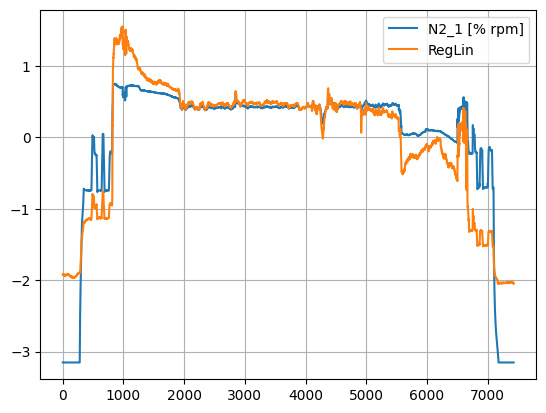

In [3]:
variableNames = ["N1_1 [% rpm]", "T1_1 [deg C]", "ALT [ft]", "M [Mach]"]
# X = ddf.partitions[0][variableNames].compute().values
f = open("variables.npy", "rb")
X = np.load(f)
f.close()
Xnorm = (X - X.mean(axis=0)) / X.std(axis=0)
Xhat = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), Xnorm), axis=1)

targetName = ["N2_1 [% rpm]"]
# y = ddf.partitions[0][targetName].compute().values.reshape(-1, 1)
f = open("target.npy", "rb")
y = np.load(f)
f.close()

yNorm = (y - y.mean(axis=0)) / y.std(axis=0)

aHat = np.linalg.solve(np.matmul(Xhat.transpose(), Xhat),
                       np.matmul(Xhat.transpose(), yNorm))
yHat = np.matmul(Xhat, aHat)


plt.figure()
plt.plot(yNorm, label=targetName[0])
plt.plot(yHat, label="RegLin")
plt.legend()
plt.grid("on")
plt.show()


In [4]:
# f = open("variables.npy", "wb")
# np.save(f, X)
# f.close()

In [5]:
# f = open('target.npy', "wb")
# np.save(f, y)
# f.close()

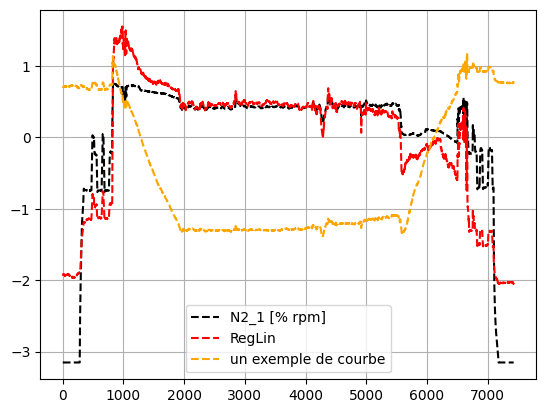

In [5]:
nbFeatures = 4
nbTarget = 1
Lin = nn.Linear(nbFeatures, nbTarget)

tXhat = torch.Tensor(Xhat[:,1:])
tyNorm =torch.Tensor(yNorm)
tyHat = torch.Tensor(yHat)

plt.figure()
plt.plot(tyNorm, label = targetName[0], color = 'k', linestyle = 'dashed')
plt.plot(tyHat, label = "RegLin", color = 'red', linestyle = 'dashed')
plt.plot(Lin(tXhat).detach().numpy(), label = "un exemple de courbe", color = 'orange', linestyle = 'dashed')
plt.legend()
plt.grid("on")
plt.show()

In [6]:
# Hypperparamètres
N = 2000
lmax = 6
P0 = 0.1
epsilon = 0.01
fact = 0.8
sigma_0 = (lmax + 1) * fact
ns = [4,1]
activation = "relu"

# Temperature initiale
Temp = 0.05

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

In [7]:
# Ici on commence l'algorithm BNN-ABC-SS
# Notre modèle
myModel = BNN.FNN(ns, activation)
myModelSize = BNN.modelSize(ns)

# Distribution a priori
thetaPrior = ot.Normal(0, sigma_0)
thetas = torch.randn(myModelSize, N) * sigma_0
# Fixe la variance de la distribution de proposition
sigma_j = sigma_0

# Feedforward
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(tXhat) for i in range(0, N)]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(y_hats.t(), tyNorm.t(), p=pdist) ** 2)/ myModelSize

#  
rhoMin = []
rhoMax = []

#
NP0 = int(N*P0)
invP0 = int(1/P0)
j = 0

# reglage de temperature
t = 0
TempCur = Temp
while (rhos[0, 0] > epsilon):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = thetas[:, indices.t()[0]]

    epsilon_j = rhos[NP0]

    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:, :NP0]
    rhoSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - fact * lmax

    #
    thetas = thetasSeeds
    rhos = rhos[:NP0]

    for g in range(invP0 - 1):
        # thetasResamples = torch.normal(thetasSeeds, sigma_j)
        thetasResamples = thetasSeeds + \
            torch.randn(thetasSeeds.shape) * sigma_j

        # redimensionement des thetas
        tThetasSeeds = thetasSeeds.t().ravel().reshape(myModelSize * NP0, 1)
        tThetasResamples = thetasResamples.t().ravel().reshape(myModelSize * NP0, 1)

        # Calcul des probabilité p(theta^{(n-1)}) (seeds) et p(theta') (Resamples)
        ptThetasSeeds = torch.Tensor(
            thetaPrior.computePDF(tThetasSeeds.detach().numpy()))
        ptThetasResamples = torch.Tensor(
            thetaPrior.computePDF(tThetasResamples.detach().numpy()))

        rj = torch.exp(( ptThetasResamples - ptThetasSeeds )/ TempCur)
        # rj = ptThetasResamples / ptThetasSeeds

        sj = torch.minimum(torch.ones(myModelSize * NP0, 1), rj)
        
        # bj = torch.bernoulli(sj)
        bj = (torch.rand(sj.shape) <= sj).float()

        thetasNow = (bj * tThetasResamples + (1 - bj) *
                     tThetasSeeds).reshape(NP0, myModelSize).t()
        
        # On evalue les erreurs
        y_hatsNow = torch.concat(
            tuple([myModel.update_weights(thetasNow[:, i]).forward(tXhat) for i in range(0, NP0)]), 1)        
        rhoNow = (torch.cdist(y_hatsNow.t(), tyNorm.t(), p=pdist) ** 2) / myModelSize
        mask = torch.diag((rhoNow <= epsilon_j).ravel().float())
        
        rhoVal = mask @ rhoNow + (torch.eye(NP0) - mask) @ rhoSeeds
        thetaVal = thetasNow @ mask + thetasSeeds @ (torch.eye(NP0) - mask)

        # Mise à jour
        thetasSeeds = thetaVal
        thetas = torch.concatenate((thetas, thetasSeeds), 1)
        rhoSeeds = rhoVal
        rhos = torch.concatenate((rhos, rhoSeeds))

        # Réglage de la température
        TempCur = Temp / np.log(2 + t)
        t +=1

    j += 1
    if (j >= lmax):
        break


<!-- acceptance probability  $p(\theta_k^{(j-1), g} = \theta' | \theta_k^{(j-1), g-1}) = \min\left\{1, \exp \left( -  \frac{p(\theta') \mathbf{1}_{\mathcal{N}_{\epsilon_j} (D)} (y | x, \theta') - p\left(\theta_k^{(j-1), g-1}\right)}{T_{cur}} \right)\right\}$

For modified MCMC, instead of sampling a vector $\theta' \sim q(\theta' | \theta^{g-1})$, 

we sample it coordinate by coordinate $\theta_i' \sim q(\theta_i' | \theta^{g-1}_i)$

Given a symetric proposition distribution $q( \theta' | \theta) = q(\theta | \theta')$

we get $\forall i$ the accpetance probability is $\min\left\{1, \exp\left( \frac{p(\theta_i') - p(\theta_i^{g-1})}{T_{cur}}\right)\right\}$

Once we get the new coordinates, we accept $\^\theta$ if $ y | x, \^\theta \in \mathcal{N}_{\epsilon_j}(D)$

links : 

+ https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm
+ https://en.wikipedia.org/wiki/Genetic_algorithm
+ https://en.wikipedia.org/wiki/Simulated_annealing -->

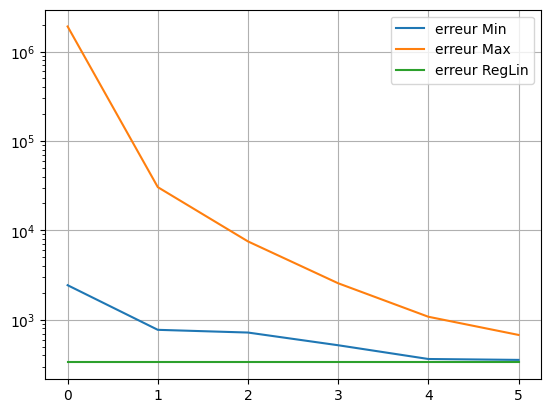

In [10]:
rhoFloor = torch.ones(lmax) *  (torch.cdist(tyNorm.t(), tyHat.t(), p=pdist) ** 2) / myModelSize
plt.figure()
plt.plot(np.float32(rhoMin), label = 'erreur Min')
plt.plot(np.float32(rhoMax), label = 'erreur Max')
plt.plot(rhoFloor.t(), label = 'erreur RegLin')
plt.plot()
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [11]:
# Feedforward
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(tXhat) for i in range(0, N)]), 1)

q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

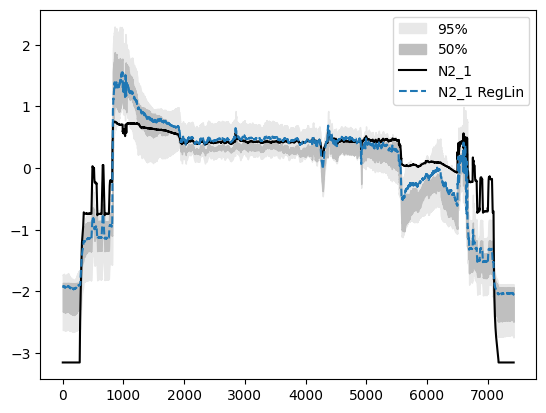

In [15]:
plt.clf()


plt.fill_between(np.arange(tyNorm.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(tyNorm.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

# plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(tyNorm, label='N2_1', color = 'k')

plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()


In [16]:
# Hypperparamètres
N = 5000
lmax = 6
P0 = 0.1
epsilon = 0.01
fact = 0.5
sigma_0 = (lmax + 1) * fact
ns = [4,2,1]
activation = "relu"
# Temperature initiale
Temp = 1

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

In [21]:
# Ici on commence l'algorithm BNN-ABC-SS
# Notre modèle
myModel = BNN.FNN(ns, activation)
myModelSize = BNN.modelSize(ns)

# Distribution a priori
thetaPrior = ot.Normal(0, sigma_0)
thetas = torch.randn(myModelSize, N) * sigma_0
# Fixe la variance de la distribution de proposition
sigma_j = sigma_0

# Feedforward
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(tXhat) for i in range(0, N)]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(y_hats.t(), tyNorm.t(), p=pdist) ** 2)/ myModelSize

#  
rhoMin = []
rhoMax = []

#
NP0 = int(N*P0)
invP0 = int(1/P0)
j = 0

# reglage de temperature
t = 0
TempCur = Temp
while (rhos[0, 0] > epsilon):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = thetas[:, indices.t()[0]]

    epsilon_j = rhos[NP0]

    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:, :NP0]
    rhoSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - fact * lmax

    #
    thetas = thetasSeeds
    rhos = rhos[:NP0]

    for g in range(invP0 - 1):
        # thetasResamples = torch.normal(thetasSeeds, sigma_j)
        thetasResamples = thetasSeeds + \
            torch.randn(thetasSeeds.shape) * sigma_j

        # redimensionement des thetas
        tThetasSeeds = thetasSeeds.t().ravel().reshape(myModelSize * NP0, 1)
        tThetasResamples = thetasResamples.t().ravel().reshape(myModelSize * NP0, 1)

        # Calcul des probabilité p(theta^{(n-1)}) (seeds) et p(theta') (Resamples)
        ptThetasSeeds = torch.Tensor(
            thetaPrior.computePDF(tThetasSeeds.detach().numpy()))
        ptThetasResamples = torch.Tensor(
            thetaPrior.computePDF(tThetasResamples.detach().numpy()))

        rj = torch.exp(( ptThetasResamples - ptThetasSeeds )/ TempCur)
        # rj = ptThetasResamples / ptThetasSeeds

        sj = torch.minimum(torch.ones(myModelSize * NP0, 1), rj)
        
        # bj = torch.bernoulli(sj)
        bj = (torch.rand(sj.shape) <= sj).float()

        thetasNow = (bj * tThetasResamples + (1 - bj) *
                     tThetasSeeds).reshape(NP0, myModelSize).t()
        
        # On evalue les erreurs
        y_hatsNow = torch.concat(
            tuple([myModel.update_weights(thetasNow[:, i]).forward(tXhat) for i in range(0, NP0)]), 1)        
        rhoNow = (torch.cdist(y_hatsNow.t(), tyNorm.t(), p=pdist) ** 2) / myModelSize
        mask = torch.diag((rhoNow <= epsilon_j).ravel().float())
        
        rhoVal = mask @ rhoNow + (torch.eye(NP0) - mask) @ rhoSeeds
        thetaVal = thetasNow @ mask + thetasSeeds @ (torch.eye(NP0) - mask)

        # Mise à jour
        thetasSeeds = thetaVal
        thetas = torch.concatenate((thetas, thetasSeeds), 1)
        rhoSeeds = rhoVal
        rhos = torch.concatenate((rhos, rhoSeeds))

        # Réglage de la température
        TempCur = Temp / np.log(2 + t)
        t +=1

    j += 1
    if (j >= lmax):
        break


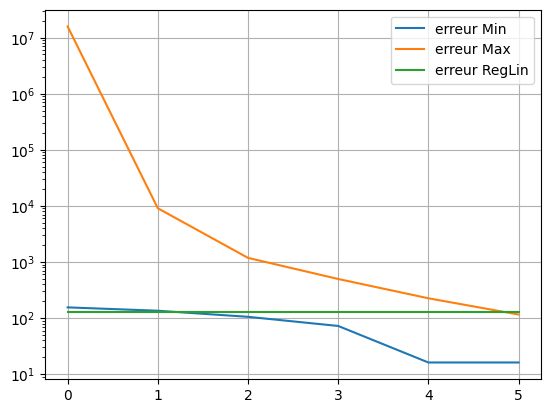

In [22]:
rhoFloor = torch.ones(lmax) *  (torch.cdist(tyNorm.t(), tyHat.t(), p=pdist) ** 2) / myModelSize
plt.figure()
plt.plot(np.float32(rhoMin), label = 'erreur Min')
plt.plot(np.float32(rhoMax), label = 'erreur Max')
plt.plot(rhoFloor.t(), label = 'erreur RegLin')
plt.plot()
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [23]:
# Feedforward
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(tXhat) for i in range(0, N)]), 1)

q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

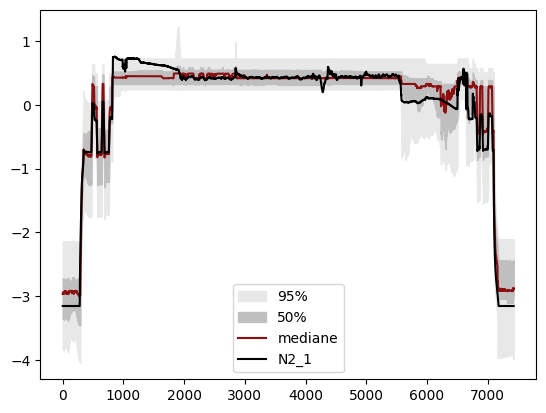

In [24]:
plt.clf()


plt.fill_between(np.arange(tyNorm.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(tyNorm.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(tyNorm, label='N2_1', color = 'k')

# plt.plot(tyHat, label="N2_1 prédit", linestyle='dashed')

plt.legend()
plt.show()
